### Modeling Cyanobacteria Blooms in Lake Champlain

To do:
Data cleaning and exploration:
- get data with:
    - rows with missing cyanobac removed
    - missing values removed or replaced with monthly averages
    - month and N:P and target columns added
    - target +1timestep added
- look at histogram/distribution of cyanobac values

Try each of the following:
- linear regression - MC
- logistic regression - TL
- SVM with various kernels -TL
- random forest - MC

Also look at:
- look at the data with PCA?
- use a feature importance function from sci kit learn to look at that...?

In [29]:
#Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

In [30]:
#Load data
path = os.getcwd() + '/data/AllSites.csv'
ds1 = pd.read_csv(path)

#Remove rows with missing cyanobacteria values
ds1 = ds1.dropna(axis=0, subset = ['NP_Cya_bio'])

#Remove rows with any missing value.
#ds1 = ds1.dropna(axis=0, how='any')

#Add target column
ds1['target'] = [1 if x >= 4e8 else 0 for x in ds1['NP_Cya_bio']]

print(ds1.shape)
print(type(ds1))
print(ds1[ds1['target'] == 1])


(1431, 15)
<class 'pandas.core.frame.DataFrame'>
      StationID                 Station      Date    Time Stratum Depth  \
936           9     Otter Creek Segment  08/18/11  1235.0       E   4.6   
940           9     Otter Creek Segment  09/02/11  1140.0       E     3   
3037         40          St. Albans Bay  08/06/14  1210.0       U   2.2   
3038         40          St. Albans Bay  08/19/14  1010.0       U   2.6   
3269         50          Missisquoi Bay  09/22/06  1100.0       U   2.2   
3271         50          Missisquoi Bay  10/06/06  1100.0       U   2.6   
3307         50          Missisquoi Bay  08/20/08  1050.0       U     2   
3400         50          Missisquoi Bay  07/30/13  1020.0       U     3   
3461         51  Missisquoi Bay Central  09/07/06  1055.0       U   2.4   
3464         51  Missisquoi Bay Central  09/22/06  1040.0       U     2   
3499         51  Missisquoi Bay Central  08/06/08  1115.0       U     2   
3556         51  Missisquoi Bay Central  08/12/11  

Text(0, 0.5, 'Frequency')

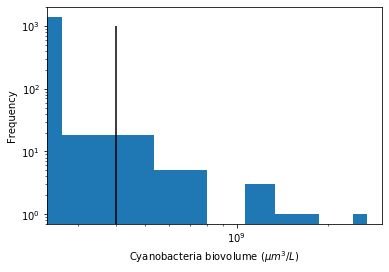

In [27]:
#Make a histogram to look at distribution of cyanobacteria biovolumes
plt.hist(ds1['NP_Cya_bio'], bins = 10)
plt.xscale('log')
plt.yscale('log')
plt.vlines(4e8, 0, 1e3)
plt.xlabel('Cyanobacteria biovolume ($\mu m^3/L$)')
plt.ylabel('Frequency')

In [40]:
#Create cleaned dataframe, ds2:
ds2 = ds1.drop(['StationID', 'Station', 'Date', 'Time', 'Stratum', 'Depth'], axis=1)

#Use regex to remove 'H's and 'J's
ds2['Month'] = ds1['Date'].astype(str).str.extract('(\d\d)').astype(int) # This is just the month number
ds2['TP'] = ds1['TP'].astype(str).str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
ds2['DP'] = ds1['DP'].astype(str).str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
ds2['Cl'] = ds1['Cl'].astype(str).str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
ds2['TN'] = ds1['TN'].astype(str).str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
ds2['TempC'] = ds1['TempC'].astype(str).str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
ds2['Chla'] = ds1['Chla'].astype(str).str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
ds2['Secchi'] = ds1['Secchi'].astype(str).str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
ds2['N:P'] = ((ds2['TN']*1e-3)/14.007)/((ds2['TP']*1e-6)/30.974) #for TN in ds2['TN'] for TP in ds2['TP']]

#Drop cyanobac biovolumes
ds2 = ds2.drop(['NP_Cya_bio'], axis=1)

#Assign X and y
X = np.array(ds2.drop(['target'], axis=1))
y = np.array(ds2['target'])

#print((ds2))
print(type(X))
print(type(y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
